## Part 1: Network Training

### Step0: Import Package & Hyperparameter Configuration

In [43]:
%reset -f


import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 1000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002
    LR_SCHEDULER_GAMMA = 0.99
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Step1: Data processing and data loader generate 

In [46]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack((data_H, data_H[:, :n_init]))  #*(Date:241216)

    # 3. Format data into tensors
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length,
                                      1).float()  #*(Date:241216)
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 4. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 5. Extra features
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 6. Create dataloader to speed up data processing
    test_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H  # 目標值 H（128 點）
    )

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=Config.BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0,
                                              collate_fn=filter_input,
                                              drop_last=False)

    return test_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    # target_H = torch.stack(target_H)  # H 的目標值（128 點）

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0

In [47]:
# %%
# Material normalization data (1.B 2.H 3.F 4.T 5.dB/dt 6.Pv)
normsDict = {
    "Material A": [[-4.02296069e-19, 6.42790612e-02],
                   [1.15118525e-01, 1.22041107e+01],
                   [5.16368866e+00, 2.68540382e-01],
                   [5.52569885e+01, 2.61055470e+01],
                   [2.42224485e-01, 2.37511802e+00],
                   [4.94751596e+00, 8.27844262e-01]],
    "Material B": [[6.75135623e-20, 6.27030179e-02],
                   [3.95575739e-02, 7.62486081e+00],
                   [5.26432657e+00, 2.88519919e-01],
                   [5.80945930e+01, 2.40673885e+01],
                   [2.72521585e-01, 2.46433449e+00],
                   [5.05083704e+00, 7.10303366e-01]],
    "Material C": [[-7.61633305e-19, 7.95720905e-02],
                   [1.11319124e-01, 1.30629103e+01],
                   [5.18559408e+00, 2.68714815e-01],
                   [5.84123573e+01, 2.40717468e+01],
                   [3.26634765e-01, 3.03949690e+00],
                   [4.74633312e+00, 8.05532336e-01]],
    "Material D": [[-3.82835526e-18, 8.10498434e-02],
                   [-1.14488902e-02, 2.83868927e+01],
                   [5.25141287e+00, 2.50821203e-01],
                   [6.72413788e+01, 2.59518223e+01],
                   [3.00584078e-01, 3.24369454e+00],
                   [5.01819372e+00, 8.41059685e-01]],
    "Material E": [[-4.22607249e-18, 1.28762770e-01],
                   [3.88389004e-01, 4.80431443e+01],
                   [5.18909550e+00, 2.77695119e-01],
                   [5.64505730e+01, 2.46127701e+01],
                   [6.35038793e-01, 5.19237566e+00],
                   [5.68955612e+00, 7.26979315e-01]]
}

### Step2: Define Network Structure

In [48]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):

    def __init__(self,
                 Material,
                 hidden_size=Config.HIDDEN_SIZE,
                 operator_size=Config.OPERATOR_SIZE,
                 input_size=3,
                 var_size=2,
                 output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        batch_size = x.size(0)
        seq_size = x.size(1)
        self.rnn1_hx = s0

        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)
            H_hyst_pred = self.dnn1(dnn1_in)

            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)
            H_eddy = self.dnn2(self.rnn2_hx)
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        B = (x[:, n_init:, 0:1] * self.norm[0][1] + self.norm[0][0])
        H = (output[:, n_init:, :] * self.norm[1][1] + self.norm[1][0])
        Pcv = torch.trapz(H, B, axis=1) * (10**(var[:, 0:1] * self.norm[2][1] +
                                                self.norm[2][0]))
        return torch.flatten(Pcv)


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

### Step3: Training the Model

In [49]:
# %%
def load_dataset(material, base_path="./Data/Testing/final-testing/"):
    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    return data_B, data_F, data_T, data_H, data_Pcv


C:\Users\USER\AppData\Local\Temp\ipykernel_52976\1405107006.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(net_file, map_location=device)


MMINet(
  (dnn1): Linear(in_features=32, out_features=1, bias=True)
  (rnn2): EddyCell(
    (x2h): Linear(in_features=4, out_features=30, bias=False)
    (h2h): Linear(in_features=30, out_features=30, bias=False)
  )
  (dnn2): Linear(in_features=30, out_features=1, bias=True)
)
模型大小1084


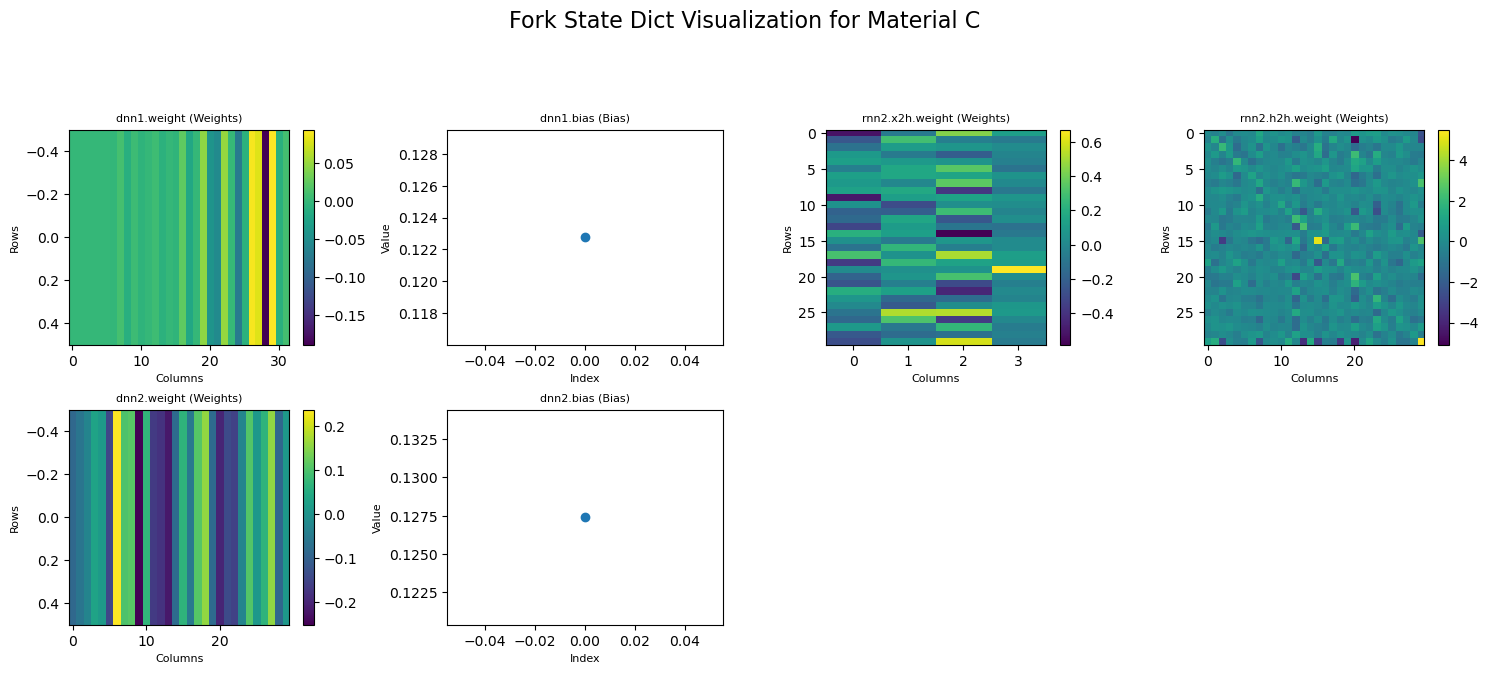

In [ ]:
Material = "Material C"
team_name = "Fork"

if team_name == "Fork":
    net_file = f"./Model/{Material}.pt"
elif team_name == "Sydney":
    net_file = f"./OLD_thing/{Material}.pt"


def count_parameters(state_dict):
    total_params = sum(p.numel() for p in state_dict.values())  # 所有參數的數量
    return total_params


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MMINet(Material).to(device)
state_dict = torch.load(net_file, map_location=device)
net.load_state_dict(state_dict, strict=True)

print(net)
print("==============================")
params_size = count_parameters(state_dict)
print(f"模型大小{params_size}")
print("==============================")

# 初始化圖表
plt.figure(figsize=(15, 15))
layer_idx = 1  # 層的索引，用於圖表標記

# 遍歷每一層的參數
for param_name, param_value in net.state_dict().items():
    param_value = param_value.cpu().numpy()  # 將張量轉為 NumPy 陣列
    plt.subplot(5, 4, layer_idx)  # 假設最多 20 層，動態調整子圖的排布
    layer_idx += 1

    # 繪製參數分佈圖
    if len(param_value.shape) == 1:  # 偏置參數 (1D)
        plt.plot(param_value, marker='o', linestyle='--')
        plt.title(f"{param_name} (Bias)", fontsize=8)
        plt.xlabel("Index", fontsize=8)
        plt.ylabel("Value", fontsize=8)
    elif len(param_value.shape) == 2:  # 權重參數 (2D)
        plt.imshow(param_value, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f"{param_name} (Weights)", fontsize=8)
        plt.xlabel("Columns", fontsize=8)
        plt.ylabel("Rows", fontsize=8)
    else:
        plt.text(0.5, 0.5, "Skipped", fontsize=12, ha='center')
        plt.title(f"{param_name} (Skipped)", fontsize=8)

    plt.tight_layout()

# 顯示圖表
plt.suptitle(f"{team_name} State Dict Visualization for {Material}",
             fontsize=16)
plt.subplots_adjust(top=0.9)  # 調整整體排版
plt.show()


In [67]:
# 測試數據加載
data_B, data_F, data_T, data_H, data_Pcv = load_dataset(Material)
norm = normsDict[Material]
test_loader = get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm)


# 模型推理
def evaluate_model(model, loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for inputs, features, s0 in loader:
            inputs, features, s0 = inputs.to(device), features.to(
                device), s0.to(device)
            outputs.append(model(inputs, features, s0).cpu().numpy())
    return np.concatenate(outputs, axis=0)


# 比較輸出
your_outputs = evaluate_model(your_model, test_loader)
team_outputs = evaluate_model(team_model, test_loader)

# 計算輸出差異
diff = np.abs(your_outputs - team_outputs).mean()
print(f"模型輸出平均差異: {diff:.6f}")


NameError: name 'your_model' is not defined